In [1]:
import pandas as pd
import numpy as np
import time
import os
import sys
import gc
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")

### Import Data Frame and create raw X and y arrays

In [2]:
t0 = time.time()
df = pd.read_csv('ipums.csv.gz')
t1 = time.time()
print("Time to read data via pandas: %r" % (t1-t0))

Time to read data via pandas: 84.99154281616211


In [3]:
target = df.columns[-1] # last column is the response
cols = [c for c in df.columns if c != target]

X = np.array(df.ix[:,cols], dtype='float64')
y = np.array(df[target].values, dtype='float64')
print(X.shape)
print(y.shape)

df = None # free mem
gc.collect()

(55776, 9732)
(55776,)


38

### scikit-learn ElasticNet

* Elastic Net Regression for Gaussian distribution
* predict last column INCEARN from all other columns
* Perform 5-fold cross-validation
* Compute validation RMSE
* Note: assume the dataset is dense, even though it isn't in this instance

In [5]:
t_init = time.time()
path_params = {'random_state':42, 'fit_intercept':True, 'cv':5, 'n_jobs': 32,
               'normalize':True, 'precompute':True, 'max_iter':1000, 'verbose':True}

# l1_ratio is the elastic net mixing parameter
# alpha is the regularization strength
alpha_max = [-5, -5, -5, -5, -5, -4, -3 ,-2] # in log-space
frames = []
model_times = []
user_alphas = []

j = 0
for l1_ratio in np.linspace(0,1,8):
    if l1_ratio == 0:
        l1_ratio = 1e-4
        
    alphas = np.logspace(1, alpha_max[j], 100)
    print('alphas:')
    print(alphas)
    
    path_params['l1_ratio'] = l1_ratio
    path_params['alphas'] = alphas
    enetcv = ElasticNetCV()
    enetcv.set_params(**path_params)
    print enetcv
    
    t0 = time.time()
    enetcv.fit(X,y)
    t1 = time.time()
    model_times.append(t1-t0)
    user_alphas.append(alphas)
    print("Time for 5-fold cv with full regularization path for l1_ratio=%r : %r" % (l1_ratio, (t1-t0)))

    
    dflist = []

    for i in range(5):
        results = {}
        results['l1_ratio'] = [l1_ratio] * len(enetcv.alphas_) 
        results['fold'] = [i] * len(enetcv.alphas_) 
        results['alphas'] = enetcv.alphas_
        results['RMSE'] = np.sqrt(enetcv.mse_path_[:,i])
        df = pd.DataFrame(results) 
        dflist.append(df)

    df_results = pd.concat(dflist)
    frames.append(df_results)
    j += 1
    
df = pd.concat(frames)

t_final = time.time()
print("Time for 5-fold cv with full regularization path: %r" % (t_final-t_init))

alphas:
[  1.00000000e+01   8.69749003e+00   7.56463328e+00   6.57933225e+00
   5.72236766e+00   4.97702356e+00   4.32876128e+00   3.76493581e+00
   3.27454916e+00   2.84803587e+00   2.47707636e+00   2.15443469e+00
   1.87381742e+00   1.62975083e+00   1.41747416e+00   1.23284674e+00
   1.07226722e+00   9.32603347e-01   8.11130831e-01   7.05480231e-01
   6.13590727e-01   5.33669923e-01   4.64158883e-01   4.03701726e-01
   3.51119173e-01   3.05385551e-01   2.65608778e-01   2.31012970e-01
   2.00923300e-01   1.74752840e-01   1.51991108e-01   1.32194115e-01
   1.14975700e-01   1.00000000e-01   8.69749003e-02   7.56463328e-02
   6.57933225e-02   5.72236766e-02   4.97702356e-02   4.32876128e-02
   3.76493581e-02   3.27454916e-02   2.84803587e-02   2.47707636e-02
   2.15443469e-02   1.87381742e-02   1.62975083e-02   1.41747416e-02
   1.23284674e-02   1.07226722e-02   9.32603347e-03   8.11130831e-03
   7.05480231e-03   6.13590727e-03   5.33669923e-03   4.64158883e-03
   4.03701726e-03   3.5111

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed: 15.5min remaining: 23.2min
....[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed: 17.1min finished


Time for 5-fold cv with full regularization path for l1_ratio=0.0001 : 1350.2848880290985
alphas:
[  1.00000000e+01   8.69749003e+00   7.56463328e+00   6.57933225e+00
   5.72236766e+00   4.97702356e+00   4.32876128e+00   3.76493581e+00
   3.27454916e+00   2.84803587e+00   2.47707636e+00   2.15443469e+00
   1.87381742e+00   1.62975083e+00   1.41747416e+00   1.23284674e+00
   1.07226722e+00   9.32603347e-01   8.11130831e-01   7.05480231e-01
   6.13590727e-01   5.33669923e-01   4.64158883e-01   4.03701726e-01
   3.51119173e-01   3.05385551e-01   2.65608778e-01   2.31012970e-01
   2.00923300e-01   1.74752840e-01   1.51991108e-01   1.32194115e-01
   1.14975700e-01   1.00000000e-01   8.69749003e-02   7.56463328e-02
   6.57933225e-02   5.72236766e-02   4.97702356e-02   4.32876128e-02
   3.76493581e-02   3.27454916e-02   2.84803587e-02   2.47707636e-02
   2.15443469e-02   1.87381742e-02   1.62975083e-02   1.41747416e-02
   1.23284674e-02   1.07226722e-02   9.32603347e-03   8.11130831e-03
   7.

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed: 11.5min remaining: 17.3min
...[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed: 12.4min finished


Time for 5-fold cv with full regularization path for l1_ratio=0.14285714285714285 : 967.3578448295593
alphas:
[  1.00000000e+01   8.69749003e+00   7.56463328e+00   6.57933225e+00
   5.72236766e+00   4.97702356e+00   4.32876128e+00   3.76493581e+00
   3.27454916e+00   2.84803587e+00   2.47707636e+00   2.15443469e+00
   1.87381742e+00   1.62975083e+00   1.41747416e+00   1.23284674e+00
   1.07226722e+00   9.32603347e-01   8.11130831e-01   7.05480231e-01
   6.13590727e-01   5.33669923e-01   4.64158883e-01   4.03701726e-01
   3.51119173e-01   3.05385551e-01   2.65608778e-01   2.31012970e-01
   2.00923300e-01   1.74752840e-01   1.51991108e-01   1.32194115e-01
   1.14975700e-01   1.00000000e-01   8.69749003e-02   7.56463328e-02
   6.57933225e-02   5.72236766e-02   4.97702356e-02   4.32876128e-02
   3.76493581e-02   3.27454916e-02   2.84803587e-02   2.47707636e-02
   2.15443469e-02   1.87381742e-02   1.62975083e-02   1.41747416e-02
   1.23284674e-02   1.07226722e-02   9.32603347e-03   8.111308

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed: 15.9min remaining: 23.9min
..[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed: 16.2min finished


Time for 5-fold cv with full regularization path for l1_ratio=0.2857142857142857 : 1192.7452640533447
alphas:
[  1.00000000e+01   8.69749003e+00   7.56463328e+00   6.57933225e+00
   5.72236766e+00   4.97702356e+00   4.32876128e+00   3.76493581e+00
   3.27454916e+00   2.84803587e+00   2.47707636e+00   2.15443469e+00
   1.87381742e+00   1.62975083e+00   1.41747416e+00   1.23284674e+00
   1.07226722e+00   9.32603347e-01   8.11130831e-01   7.05480231e-01
   6.13590727e-01   5.33669923e-01   4.64158883e-01   4.03701726e-01
   3.51119173e-01   3.05385551e-01   2.65608778e-01   2.31012970e-01
   2.00923300e-01   1.74752840e-01   1.51991108e-01   1.32194115e-01
   1.14975700e-01   1.00000000e-01   8.69749003e-02   7.56463328e-02
   6.57933225e-02   5.72236766e-02   4.97702356e-02   4.32876128e-02
   3.76493581e-02   3.27454916e-02   2.84803587e-02   2.47707636e-02
   2.15443469e-02   1.87381742e-02   1.62975083e-02   1.41747416e-02
   1.23284674e-02   1.07226722e-02   9.32603347e-03   8.111308

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed: 19.6min remaining: 29.4min
...[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed: 20.2min finished


Time for 5-fold cv with full regularization path for l1_ratio=0.42857142857142855 : 1424.617518901825
alphas:
[  1.00000000e+01   8.69749003e+00   7.56463328e+00   6.57933225e+00
   5.72236766e+00   4.97702356e+00   4.32876128e+00   3.76493581e+00
   3.27454916e+00   2.84803587e+00   2.47707636e+00   2.15443469e+00
   1.87381742e+00   1.62975083e+00   1.41747416e+00   1.23284674e+00
   1.07226722e+00   9.32603347e-01   8.11130831e-01   7.05480231e-01
   6.13590727e-01   5.33669923e-01   4.64158883e-01   4.03701726e-01
   3.51119173e-01   3.05385551e-01   2.65608778e-01   2.31012970e-01
   2.00923300e-01   1.74752840e-01   1.51991108e-01   1.32194115e-01
   1.14975700e-01   1.00000000e-01   8.69749003e-02   7.56463328e-02
   6.57933225e-02   5.72236766e-02   4.97702356e-02   4.32876128e-02
   3.76493581e-02   3.27454916e-02   2.84803587e-02   2.47707636e-02
   2.15443469e-02   1.87381742e-02   1.62975083e-02   1.41747416e-02
   1.23284674e-02   1.07226722e-02   9.32603347e-03   8.111308

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed: 19.9min remaining: 29.9min
......[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed: 23.0min finished


Time for 5-fold cv with full regularization path for l1_ratio=0.5714285714285714 : 1580.7505280971527
alphas:
[  1.00000000e+01   8.90215085e+00   7.92482898e+00   7.05480231e+00
   6.28029144e+00   5.59081018e+00   4.97702356e+00   4.43062146e+00
   3.94420606e+00   3.51119173e+00   3.12571585e+00   2.78255940e+00
   2.47707636e+00   2.20513074e+00   1.96304065e+00   1.74752840e+00
   1.55567614e+00   1.38488637e+00   1.23284674e+00   1.09749877e+00
   9.77009957e-01   8.69749003e-01   7.74263683e-01   6.89261210e-01
   6.13590727e-01   5.46227722e-01   4.86260158e-01   4.32876128e-01
   3.85352859e-01   3.43046929e-01   3.05385551e-01   2.71858824e-01
   2.42012826e-01   2.15443469e-01   1.91791026e-01   1.70735265e-01
   1.51991108e-01   1.35304777e-01   1.20450354e-01   1.07226722e-01
   9.54548457e-02   8.49753436e-02   7.56463328e-02   6.73415066e-02
   5.99484250e-02   5.33669923e-02   4.75081016e-02   4.22924287e-02
   3.76493581e-02   3.35160265e-02   2.98364724e-02   2.656087

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed:  5.0min remaining:  7.5min
.......[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed:  5.7min finished


Time for 5-fold cv with full regularization path for l1_ratio=0.71428571428571419 : 417.81243896484375
alphas:
[  1.00000000e+01   9.11162756e+00   8.30217568e+00   7.56463328e+00
   6.89261210e+00   6.28029144e+00   5.72236766e+00   5.21400829e+00
   4.75081016e+00   4.32876128e+00   3.94420606e+00   3.59381366e+00
   3.27454916e+00   2.98364724e+00   2.71858824e+00   2.47707636e+00
   2.25701972e+00   2.05651231e+00   1.87381742e+00   1.70735265e+00
   1.55567614e+00   1.41747416e+00   1.29154967e+00   1.17681195e+00
   1.07226722e+00   9.77009957e-01   8.90215085e-01   8.11130831e-01
   7.39072203e-01   6.73415066e-01   6.13590727e-01   5.59081018e-01
   5.09413801e-01   4.64158883e-01   4.22924287e-01   3.85352859e-01
   3.51119173e-01   3.19926714e-01   2.91505306e-01   2.65608778e-01
   2.42012826e-01   2.20513074e-01   2.00923300e-01   1.83073828e-01
   1.66810054e-01   1.51991108e-01   1.38488637e-01   1.26185688e-01
   1.14975700e-01   1.04761575e-01   9.54548457e-02   8.69749

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed:  3.5min remaining:  5.3min
[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed:  3.5min finished


Time for 5-fold cv with full regularization path for l1_ratio=0.8571428571428571 : 233.85845589637756
alphas:
[ 10.           9.32603347   8.69749003   8.11130831   7.56463328
   7.05480231   6.57933225   6.13590727   5.72236766   5.33669923
   4.97702356   4.64158883   4.32876128   4.03701726   3.76493581
   3.51119173   3.27454916   3.05385551   2.84803587   2.65608778
   2.47707636   2.3101297    2.15443469   2.009233     1.87381742
   1.7475284    1.62975083   1.51991108   1.41747416   1.32194115
   1.23284674   1.149757     1.07226722   1.           0.93260335
   0.869749     0.81113083   0.75646333   0.70548023   0.65793322
   0.61359073   0.57223677   0.53366992   0.49770236   0.46415888
   0.43287613   0.40370173   0.37649358   0.35111917   0.32745492
   0.30538555   0.28480359   0.26560878   0.24770764   0.23101297
   0.21544347   0.2009233    0.18738174   0.17475284   0.16297508
   0.15199111   0.14174742   0.13219411   0.12328467   0.1149757
   0.10722672   0.1          0.09

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................../home/hkaren/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
...................[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed: 27.5min remaining: 41.2min
..................[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed: 34.4min finished


Time for 5-fold cv with full regularization path for l1_ratio=1.0 : 2149.7573080062866
Time for 5-fold cv with full regularization path: 9317.316055059433


### Plotting the results

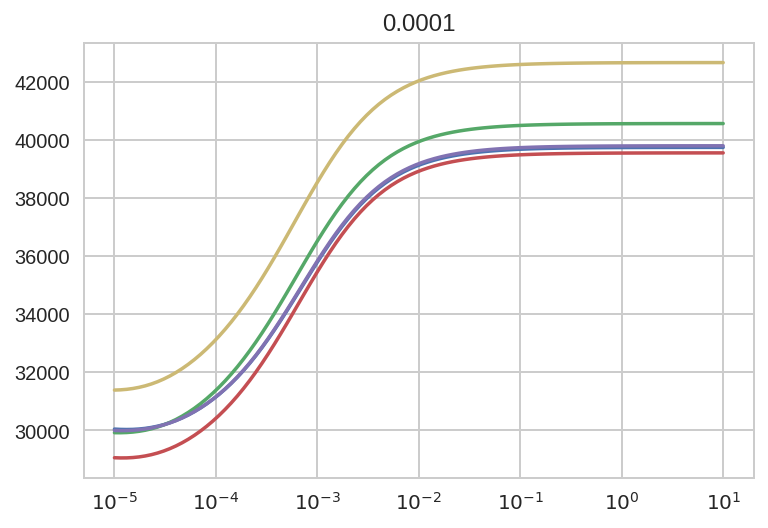

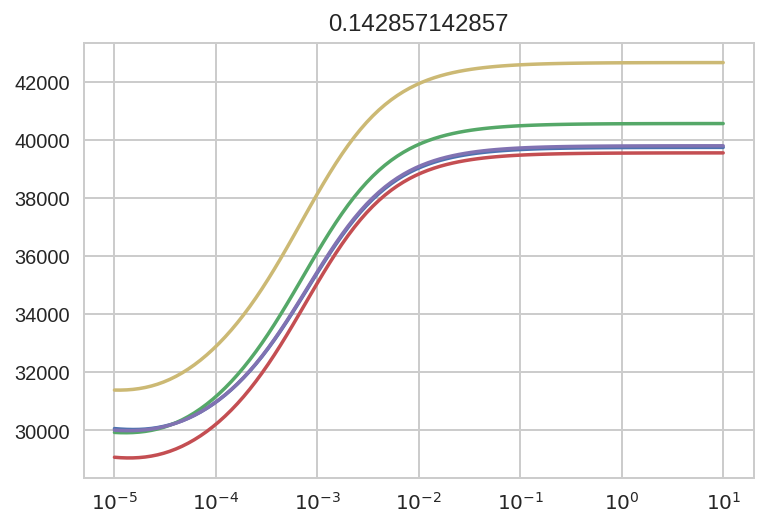

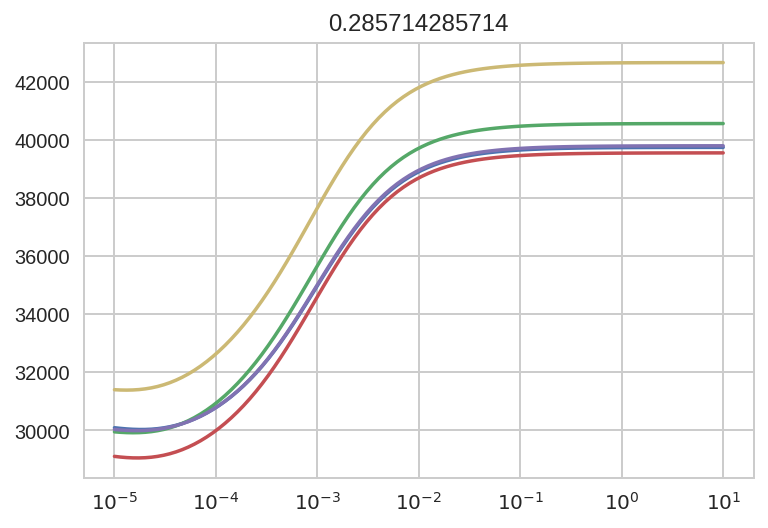

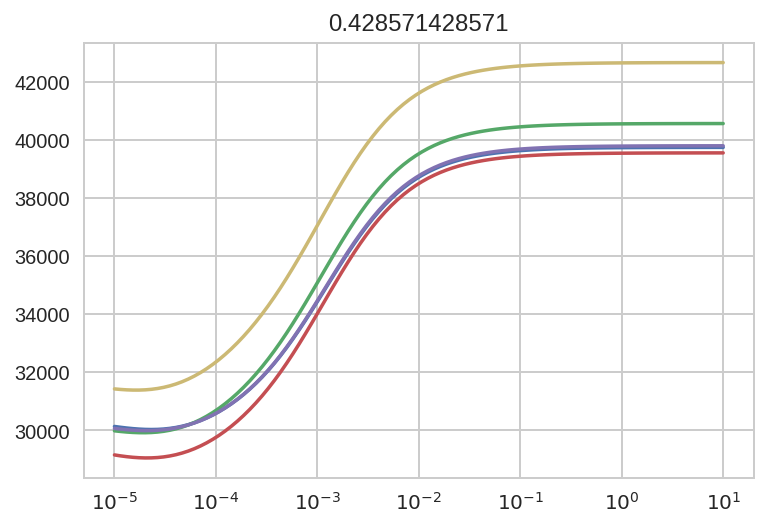

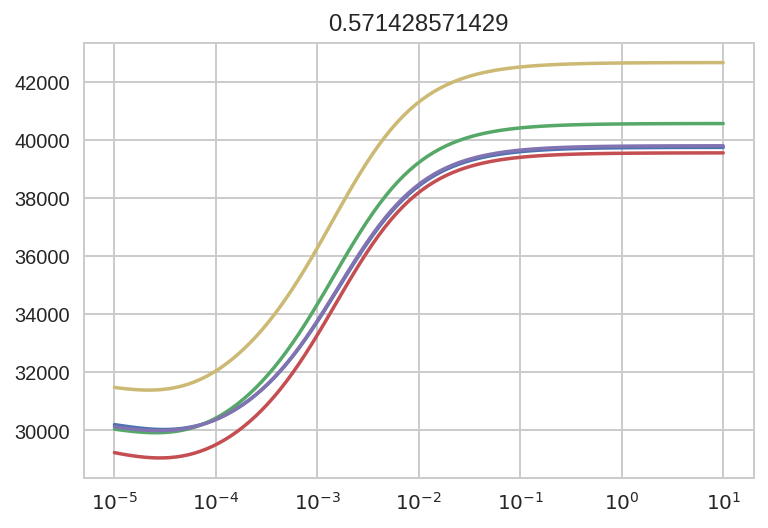

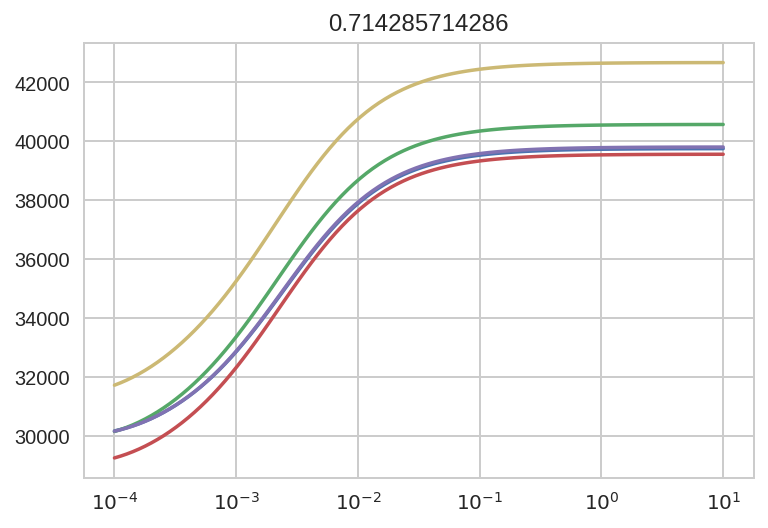

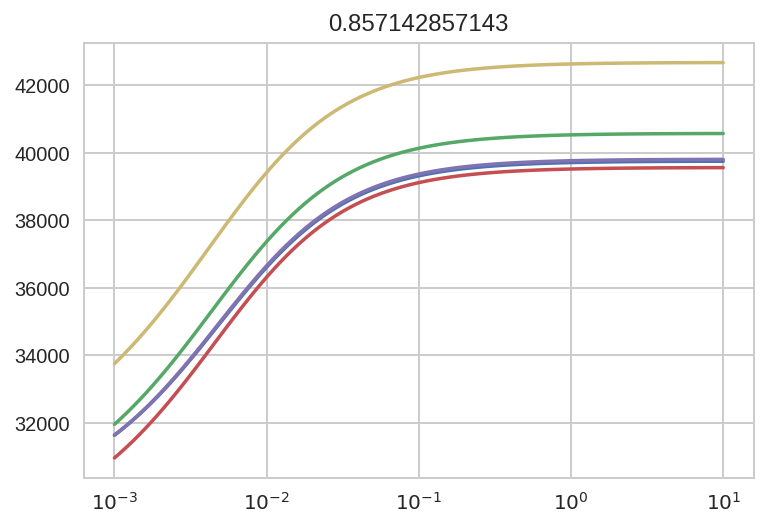

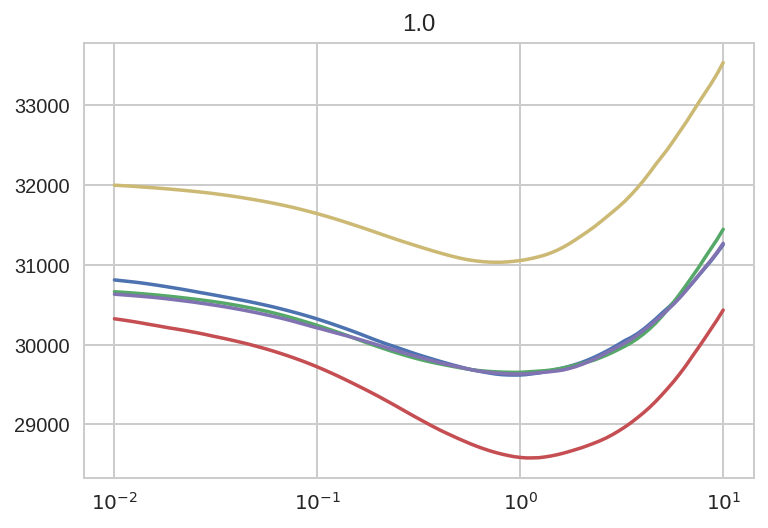

In [6]:
for l1r in df.l1_ratio.unique():
    plt.figure()
    for i in df.fold.unique():
        plt.plot(df.loc[(df.l1_ratio == l1r) & (df.fold == i), 'alphas'], 
                 df.loc[(df.l1_ratio == l1r) & (df.fold == i), 'RMSE'])
        plt.xscale('log')
        plt.title(l1r)